# Linear Regression from Scratch using PyTorch

The goal is to get a better understanding of how PyTorch implements a neural network.  

We will use the tensors, loss function and optimizers from PyTorch, but try to build everything else manually.

The hope is that problems and nuances will force us to understand the mechanisms behind the scenes not seen when we use more of the PyTorch library to help us.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn import metrics

import torch
import torch.optim as optim

### Build a random dataset that roughly follows a linear dependency

We limit the range of our slope, y-intercepts and how much variance we allow in the label

4.283214134478696 -52.08853738647598


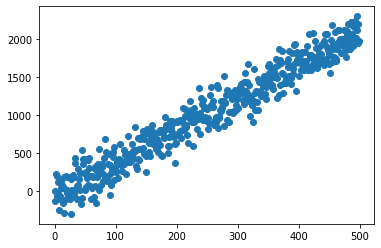

In [2]:
max_x = 500
slope_range = [.1, 10]
slope_direction = np.random.choice([-1,1])
intercept_range = [-80, 80]
residual_var = 100
X = torch.from_numpy(np.arange(max_x))
X = X.type(torch.float64)
m = np.random.uniform(*slope_range) * slope_direction
b = np.random.uniform(*intercept_range)
# m, b = -0.6346013753477167, 52.297166992434484 # mis match in magnitude, learning for b will not be good
# m, b = 5, 5
scaled_variance = np.random.normal(0, residual_var, len(X)) * m/3
y = m * X + b + scaled_variance
print(m, b)
plt.scatter(X, y)

## LinearModel

Let's build a class, but we do **not** inherit **nn.Module**.

The **train** method will be our manual **nn.Linear** transformation.

We will also build the training loop into this class just to keep things simple.


In [3]:
class LinearModel:
    def __init__(self, params):
        self.parameters = params # weights for slope and bias (could have been stored outside of model)
        self.y_pred = None # Will hold last prediction when training loop is done
        self.weight_history = [] # Will hold every parameter after step, add baseline params now
        self.weight_history.append(np.array([float(self.parameters[0][0]),float(self.parameters[0][1])]))
    def set_learning_objects(self, criterion, optimizer):
        self.criterion = criterion
        self.optimizer = optimizer
    def train(self, X):
        return self.parameters[0][0] * X + self.parameters[0][1] # Simple line with current m and b weights
    def training_loop(self, epochs, X, y):
        for epoch in [e+1 for e in range(epochs)]: # Make ephochs 1 based
            self.y_pred = self.train(X) # No batching here, run all data, adjust the weights once
            loss = self.criterion(self.y_pred, y) # What ever loss function that was passed is used
            self.optimizer.zero_grad() # Gradients sum with each back prop, so we need to zero
            loss.backward() # The acutal back proagation
            self.optimizer.step() # Updates the weights (self.parameters)
            self.weight_history.append(np.array([float(self.parameters[0][0]),float(self.parameters[0][1])]))
            if epoch % 10 == 0:
                print("Epoch: {} - Loss: {}".format(epoch, float(loss)))
    def predict(self, X):
        return self.train(X).detach().numpy()

## Model Parameters (Weights)

We need to manually build our nn weights that will be adjusted during training.

There will be 2 weights, m and b.

Even though they are single scalar values, they will need to be presented to the model as PyTorch tensors.

They also need to participate in back propagation, so they will need to be able to calculate the gradient on the forward pass (requires_grad=True).

We also want to give it some kind of value.  Let's pick a random value, but close to 0.7 for the slope and 0 for the y-intercept.

Normally, PyTorch automatically builds the parameters and initializes the values.


In [4]:
initial_slope_weights = np.random.normal(.7, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
initial_slope_weights

0.6962400033549747

In [5]:
inital_bias_weight = np.random.normal(0, .01) #No specal sauce here, but we don't want to start at the extreams (too near 0 or 1)
inital_bias_weight

-0.000512109346805413

In [6]:
#weights are a enumerable tensor.  In our simple r1 maps to r1, it is just 2 trainable paramaters
weights_bias = torch.tensor([initial_slope_weights, inital_bias_weight], requires_grad=True) # requires_grad=True maintains the state for the back prop

### Custom build Gradient Descent Optimizer

This was copied from the open source for PyTorch SGD optimizer and reduced to to make it as simple as possible.

We will try several optimizers, but this class will give us a look into how the basic mechanism works.


In [7]:
#custom optimizer, just plain old Gradiant Decent with a learning rate
class GD_Optimizer(optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(GD_Optimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p.data.add_(-group['lr'], d_p)

        return loss            

### Build Model and Set Parameters

In [8]:
model = LinearModel([weights_bias])

#hyper-parameters
epochs = 100
learning_rate = 1e-3

#loss:
# criterion = torch.nn.MSELoss()
# criterion = torch.nn.SmoothL1Loss()
# criterion = torch.nn.L1Loss()
# criterion = lambda y, y_pred : torch.mean((y - y_pred)**2)
criterion = lambda y, y_pred : torch.mean(abs(y - y_pred))

#optimizer:
# optimizer = optim.SGD(model.parameters, lr=learning_rate)
# optimizer = optim.SGD(model.parameters, lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(model.parameters)
optimizer = GD_Optimizer(model.parameters, lr=learning_rate)


model.set_learning_objects(criterion, optimizer)

## Train

If you look at the training loop, you will see there is no batching, we simply look at all the training values and adjust the weights once per epoch.

In [9]:
model.training_loop(epochs, X, y)

Epoch: 10 - Loss: 327.9797472774451
Epoch: 20 - Loss: 123.72166637659453
Epoch: 30 - Loss: 123.6219840236028
Epoch: 40 - Loss: 123.62214875022894
Epoch: 50 - Loss: 123.62229932523539
Epoch: 60 - Loss: 123.62156316166391
Epoch: 70 - Loss: 123.62167239443039
Epoch: 80 - Loss: 123.62183712084232
Epoch: 90 - Loss: 123.62191886942854
Epoch: 100 - Loss: 123.62119603850333


## Weight History

In our training loop, we keep a record of the weight values with each epoch.

So we can plot both the m and b weight values by epoch to get insight into how the model changes the slopes.

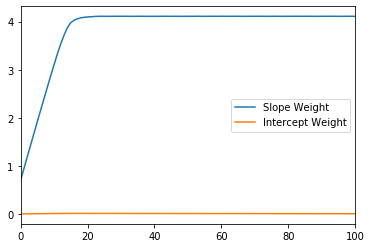

In [10]:
weightsdf = pd.DataFrame(model.weight_history, columns=['Slope Weight', 'Intercept Weight'])
weightsdf.plot()

### Lets show the actual values of m and b and the basic regression metrics (from scratch of course)

In [11]:
pred_slope = model.parameters[0][0].item()
pred_intercept = model.parameters[0][1].item()
mbdf = pd.DataFrame({
                        'Model':[pred_slope, pred_intercept],
                        'Actual':[m, b],
                        'Initial Weights':[initial_slope_weights, inital_bias_weight]
                    })
mbdf = mbdf.transpose()
mbdf.columns=['Slope', 'Intercept']
display(mbdf)

y_pred = model.predict(y)
erdf = pd.DataFrame({
                        'Mean Absolute Error':[metrics.mean_absolute_error(y, y_pred)],
                        'Mean Squared Error':[metrics.mean_squared_error(y, y_pred)],
                        'Root Mean Squared Error':[np.sqrt(metrics.mean_squared_error(y, y_pred))],
                        'R2':[metrics.r2_score(y, y_pred)]
                    })
erdf = erdf.transpose()
erdf.columns=['Metric']
display(erdf)

,Slope,Intercept
Model,4.109781,0.002972
Actual,4.283214,-52.088537
Initial Weights,0.696240,-0.000512


,Metric
Mean Absolute Error,3.185659e+03
Mean Squared Error,1.387662e+07
Root Mean Squared Error,3.725134e+03
R2,-3.321239e+01


### Show predicted line against the scatter plot

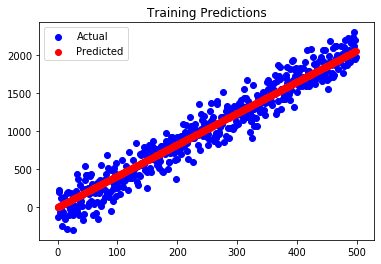

In [12]:
plt.scatter(X, y, color='b', label='Actual')
plt.scatter(X, model.y_pred.detach().numpy(), color='r', label='Predicted')
plt.title('Training Predictions')
plt.legend()
plt.show()

## Now let's look at regression on polynomials

We will pick a random polynomial of degree 3:

## $y = 2x^3 + 42x^2 + 7x + 148$

In [13]:
poly_func = lambda x:  \
                    2*torch.pow(x, 3) + \
                   42*torch.pow(x, 2) + \
                    7*torch.pow(x, 1) + \
                  148*torch.pow(x, 0)

### Let's take a quick look at what this polynomial would look like

Let will plot the function with x between -500 and 500

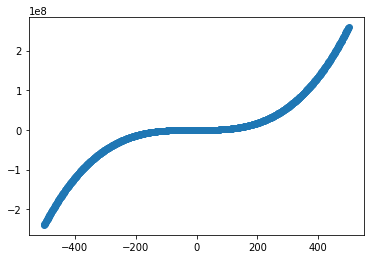

In [14]:
max_x = 500
X = torch.from_numpy(np.arange(-max_x, max_x))
y = poly_func(X)
plt.scatter(X, y)

## How do we approach a polynomial regression problem?

### Still a linear regression problem, but with multiple derived features

If we look at our original linear regression problem, we can write it as:

## $y = mx^1 + bx^0$

This gives us 2 features.

When we built our model, we had two weights, one for each feature.

With our polynomial, we will have 4 features:

## $y = {m_3}x^3 + {m_2}x^2 + {m_1}x^1 + bx^0$

So we will need 4 weights:

### ${m_3}, {m_2}, {m_1}, b$

The y-intercept is not dependent on x, so we only need to add 2 more features that we had for our linear model.


## How do we get the $x^2$ and $x^3$ features when we only have $x$?

We need to extend this single value into all 4 features:

$x^3$
$x^2$
$x^1$
$x^0$

For example, if $x=7.2$, the values for the 4 features would be:

${7.2}^3 = 372.248$

${7.2}^2 = 51.842$

${7.2}^1 = 7.2$

${7.2}^0 = 1$

We are not adding any new data, we simply are presenting the same data in 4 different ways.  Each value of x will have different values for $x^2$ and $x^3$.

#### As training progresses, these weights or coefficients become closer to the actual coefficients of our polynomial.

For $x=7.2$, we are see adjust the weights for out 4 features:


### $\hat{y} = {w_3}{372.248} + {w_2}{51.842} + {w_1}{7.2} + {w_0}{1}$

### Let's build X, but withall 4 feature we described above

*Note: We could have simply used SKLearn PolynomialFeatures transformation, but we will build it manually here to give a better understanding of what it will do.*

In [15]:
def polyFeatures(value, degree=2):
    result = []
    for i in range(degree+1): #add one since zero based, degree 2 gives 3 values [0,1,2]
        result.append(float(value)**i)
    return result
def ployFeaturePoints(start, end, stride, degree=2):
    result = []
    points = np.arange(start, end, stride)
    for i in points:
        result.append(polyFeatures(i, degree))
    return result

In [16]:
poly_X = torch.tensor(ployFeaturePoints(start=-500, end=500, stride=1, degree=3), requires_grad=True)
print('Columns:[ x^0,   x,   x^2,  x^3]')
poly_X[500:509] 

Columns:[ x^0,   x,   x^2,  x^3]


tensor([[  1.,   0.,   0.,   0.],
        [  1.,   1.,   1.,   1.],
        [  1.,   2.,   4.,   8.],
        [  1.,   3.,   9.,  27.],
        [  1.,   4.,  16.,  64.],
        [  1.,   5.,  25., 125.],
        [  1.,   6.,  36., 216.],
        [  1.,   7.,  49., 343.],
        [  1.,   8.,  64., 512.]], grad_fn=<SliceBackward>)

In [17]:
poly_y = poly_func(poly_X[:,1])
poly_y[500:509]

tensor([ 148.,  199.,  346.,  601.,  976., 1483., 2134., 2941., 3916.],
       grad_fn=<SliceBackward>)

### We now have to build 4 weights

We only had to build 2 weights for our linear regression m and b

In [18]:
bias_weight = np.random.normal(0, .01)
order_1_weight = np.random.normal(.7, .01)
order_2_weight = np.random.normal(.7, .01)
order_3_weight = np.random.normal(.7, .01)

In [19]:
polynominal_weights = torch.tensor([bias_weight, order_1_weight, order_2_weight, order_3_weight], requires_grad=True)

### We have to make 3 small changes to our model class

- Update the **train** function to predict the polynomial output
- Add retain_graph=True to the loss.backward call.  Our simple linear model was able to get away with this since the graph was so simple, but our polynomial computational graph is too complicated to build the graph on the fly.
- Add an activation function (tanh) to tame our loss to manageable values. 

In [20]:
class PolynomialModel:
    def __init__(self, params):
        self.parameters = params # weights for slope and bias (could have been stored outside of model)
        self.y_pred = None # Will hold last prediction when training loop is done
        self.weight_history = [] # Will hold every parameter after step, add baseline params now
        self.weight_history.append(np.array([float(self.parameters[0][0]),
                                                 float(self.parameters[0][1]),
                                                 float(self.parameters[0][2]),
                                                 float(self.parameters[0][3])]))
    def set_learning_objects(self, criterion, optimizer):
        self.criterion = criterion
        self.optimizer = optimizer
    def train(self, X):
        return  self.parameters[0][3] * X[:,3] + \
                self.parameters[0][2] * X[:,2] + \
                self.parameters[0][1] * X[:,1] + \
                self.parameters[0][0] * X[:,0]
    def training_loop(self, epochs, X, y):
        for epoch in [e+1 for e in range(epochs)]: # Make ephochs 1 based
            self.y_pred = self.train(X) # No batching here, run all data, adjust the weights once
            loss = torch.tanh(self.criterion(self.y_pred, y)) # What ever loss function that was passed is used
            self.optimizer.zero_grad() # Gradients sum with each back prop, so we need to zero
            loss.backward(retain_graph=True) # The acutal back proagation
            self.optimizer.step() # Updates the weights (self.parameters)
            self.weight_history.append(np.array([float(self.parameters[0][0]),
                                                 float(self.parameters[0][1]),
                                                 float(self.parameters[0][2]),
                                                 float(self.parameters[0][3])]))
            print("Epoch: {} - Loss: {}".format(epoch, float(loss)))
    def predict(self, X):
        return self.train(X).detach().numpy()

In [21]:
polyModel = PolynomialModel([polynominal_weights])

#hyper-parameters
epochs = 10
learning_rate = 1e-2

#loss
criterion = torch.nn.L1Loss() # Loss can get very big, so use L1:abs(diff) vs L2:(dif)^2
optimizer = optim.SGD(polyModel.parameters, lr=learning_rate)


polyModel.set_learning_objects(criterion, optimizer)

In [22]:
polyModel.training_loop(epochs, poly_X, poly_y)

Epoch: 1 - Loss: 1.0
Epoch: 2 - Loss: 1.0
Epoch: 3 - Loss: 1.0
Epoch: 4 - Loss: 1.0
Epoch: 5 - Loss: 1.0
Epoch: 6 - Loss: 1.0
Epoch: 7 - Loss: 1.0
Epoch: 8 - Loss: 1.0
Epoch: 9 - Loss: 1.0
Epoch: 10 - Loss: 1.0


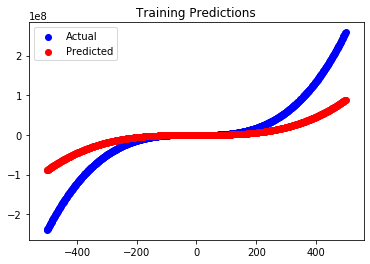

In [23]:
plt.scatter(poly_X[:,1].detach().numpy(), poly_y.detach().numpy(), color='b', label='Actual')
plt.scatter(poly_X[:,1].detach().numpy(), polyModel.y_pred.detach().numpy(), color='r', label='Predicted')
plt.title('Training Predictions')
plt.legend()
plt.show()

### We can see that we has some limited success

Note: the loss was saturated after the first epoch.

This is because our 4 features are so unbalanced.

To see this, let's look at the values for our min and max x:

In [24]:
print('Columns:[ x^0,         x,           x^2,         x^3]')
poly_X[[0,-1]] 

Columns:[ x^0,         x,           x^2,         x^3]


tensor([[ 1.0000e+00, -5.0000e+02,  2.5000e+05, -1.2500e+08],
        [ 1.0000e+00,  4.9900e+02,  2.4900e+05,  1.2425e+08]],
       grad_fn=<IndexBackward>)

### The $x$ values are -500 and 499.  

### The $x^3$ values are about +/- 125,000,000.

This makes training very difficult.  Training is done on a single scalar loss value.  

The contributions made by $x^3$ overwhelm losses from the other 3 features.

The solution is to scale the 4 features to the same min and max.

This should solve our training problem, but will have to figure out how to remove this scaling if we want to compare our final weights from the model to the known polynomial.


In [25]:
poly_X = torch.tensor(ployFeaturePoints(start=-500, end=500, stride=1, degree=3), 
                                          requires_grad=True)


max_poly_X_0, max_poly_X_1 = 1, poly_X[:,1].max()
max_poly_X_2, max_poly_X_3 = poly_X[:,2].max(),poly_X[:,3].max()
print(max_poly_X_1.detach().numpy(), max_poly_X_2.detach().numpy(), max_poly_X_3.detach().numpy())

poly_X[:,1] = poly_X[:,1] / max_poly_X_1
poly_X[:,2] = poly_X[:,2] / max_poly_X_2
poly_X[:,3] = poly_X[:,3] / max_poly_X_3

poly_X_data = poly_X.detach().numpy()

poly_X = torch.tensor(poly_X_data, requires_grad=True)


print('\nColumns:[ x^0,         scaled(x),   scaled(x^2), scaled(x^3])')
poly_X[[0, 500, 501, 508, -1]] 

499.0 250000.0 124251496.0

Columns:[ x^0,         scaled(x),   scaled(x^2), scaled(x^3])


tensor([[ 1.0000e+00, -1.0020e+00,  1.0000e+00, -1.0060e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  2.0040e-03,  4.0000e-06,  8.0482e-09],
        [ 1.0000e+00,  1.6032e-02,  2.5600e-04,  4.1207e-06],
        [ 1.0000e+00,  1.0000e+00,  9.9600e-01,  1.0000e+00]],
       grad_fn=<IndexBackward>)

## 3 changes for the scaled version

- Loss changes to the more traditional Mean Squared Error
- Remove the hack of doing tanh on loss result
- A lot more epochs since we are now doing actual training


In [26]:
class ScaledPolynomialModel:
    def __init__(self, params):
        self.parameters = params # weights for slope and bias (could have been stored outside of model)
        self.y_pred = None # Will hold last prediction when training loop is done
        self.weight_history = [] # Will hold every parameter after step, add baseline params now
        self.weight_history.append(np.array([float(self.parameters[0][0]),
                                                 float(self.parameters[0][1]),
                                                 float(self.parameters[0][2]),
                                                 float(self.parameters[0][3])]))
    def set_learning_objects(self, criterion, optimizer):
        self.criterion = criterion
        self.optimizer = optimizer
    def train(self, X):
        return  self.parameters[0][3] * X[:,3] + \
                self.parameters[0][2] * X[:,2] + \
                self.parameters[0][1] * X[:,1] + \
                self.parameters[0][0] * X[:,0]
    def training_loop(self, epochs, X, y):
        for epoch in [e+1 for e in range(epochs)]: # Make ephochs 1 based
            self.y_pred = self.train(X) # No batching here, run all data, adjust the weights once
            loss = self.criterion(self.y_pred, y) # What ever loss function that was passed is used
            self.optimizer.zero_grad() # Gradients sum with each back prop, so we need to zero
            loss.backward(retain_graph=True) # The acutal back proagation
            self.optimizer.step() # Updates the weights (self.parameters)
            self.weight_history.append(np.array([float(self.parameters[0][0]),
                                                 float(self.parameters[0][1]),
                                                 float(self.parameters[0][2]),
                                                 float(self.parameters[0][3])]))
            if epoch % 2000 == 0:
                print("Epoch: {} - Loss: {}".format(epoch, float(loss)))
    def predict(self, X):
        return self.train(X).detach().numpy()

In [27]:
polyModel = ScaledPolynomialModel([polynominal_weights])

#hyper-parameters
epochs = 40000
learning_rate = 1e-2

#loss
criterion = torch.nn.MSELoss() 
optimizer = optim.SGD(polyModel.parameters, lr=learning_rate)


polyModel.set_learning_objects(criterion, optimizer)

In [28]:
polyModel.training_loop(epochs, poly_X, poly_y)

Epoch: 2000 - Loss: 193365870116864.0
Epoch: 4000 - Loss: 50662964461568.0
Epoch: 6000 - Loss: 13274942799872.0
Epoch: 8000 - Loss: 3478348103680.0
Epoch: 10000 - Loss: 911424290816.0
Epoch: 12000 - Loss: 238831730688.0
Epoch: 14000 - Loss: 62600024064.0
Epoch: 16000 - Loss: 16416799744.0
Epoch: 18000 - Loss: 4325374976.0
Epoch: 20000 - Loss: 1144720640.0
Epoch: 22000 - Loss: 309274432.0
Epoch: 24000 - Loss: 88328600.0
Epoch: 26000 - Loss: 20937298.0
Epoch: 28000 - Loss: 8111480.0
Epoch: 30000 - Loss: 7029506.0
Epoch: 32000 - Loss: 6915908.5
Epoch: 34000 - Loss: 6916021.0
Epoch: 36000 - Loss: 6916021.0
Epoch: 38000 - Loss: 6916021.0
Epoch: 40000 - Loss: 6916021.0


## We see a nice decrease in the loss function

This takes a lot of epohs, but they were quick.

Let's plot the results.  

*Note: We will use X and not poly_x for our plot since we want to use the non-scaled version of the x-axis.*

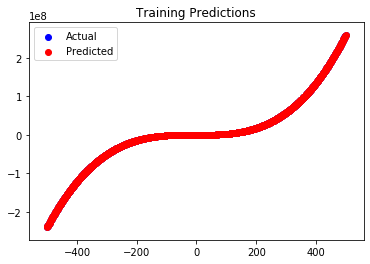

In [29]:
plt.scatter(X.detach().numpy(), poly_y.detach().numpy(), color='b', label='Actual')
plt.scatter(X.detach().numpy(), polyModel.y_pred.detach().numpy(), color='r', label='Predicted')
plt.title('Training Predictions')
plt.legend()
plt.show()

### Now let's take a look at the final weights of our model

In [30]:
w3 = polyModel.parameters[0][3].item()
w2 = polyModel.parameters[0][2].item()
w1 = polyModel.parameters[0][1].item()
w0 = polyModel.parameters[0][0].item()

print(f'w3: {w3}\nw2: {w2}\nw1: {w1}\nw0: {w0}\n')

w3: 248485712.0
w2: 10499666.0
w1: 13902.271484375
w0: 252.0009002685547



### But these don't match our actual polynomial:

## $y = 2x^3 + 42x^2 + 7x + 148$

${w3} = 2$

${w2} = 42$

${w1} = 7$

${w0} = 148$

But remember we scaled our inputs, so we have to un-scale the weights to get the coefficients:

In [31]:
w3 = w3 / max_poly_X_3
w2 = w2 / max_poly_X_2
w1 = w1 / max_poly_X_1
w0 = w0 / max_poly_X_0

print(f'w3: {w3}\nw2: {w2}\nw1: {w1}\nw0: {w0}\n')

w3: 1.9998610019683838
w2: 41.99866485595703
w1: 27.86026382446289
w0: 252.0009002685547



## Not too bad

We see the coefficients for the 2 higher order powers are more accurate, so these are probably still dominating the other 2 coefficients.
